In [68]:
#this script visualizes the contig length, coverage, 
#and taxonomy of spades-assembled contigs
#filter contigs >1000bp, >10x coverage, and those matching 
#the top genus sequenced into filter_contigs folder

In [76]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
from Bio import SeqIO

In [88]:
isolate= sys.argv[1]

In [89]:
path = 'results/processing/assemblies/'+isolate+'/'
#inputs
centrifuge_file = path + 'spades_isolate_assembly/centrifuge_hits.tsv'
fasta_file = path + 'spades_isolate_assembly/contigs.fasta'

#outputs
centrifuge_summary_file = path + 'spades_isolate_assembly/centrifuge_summary.tsv'
LvC_plot = path + 'spades_isolate_assembly/contigs_length_vs_coverage.pdf'

filtered_contigs_dir = 'results/processing/filtered_contigs'
os.system('mkdir -pv '+filtered_contigs_dir)
filtered_contigs_fasta_file = filtered_contigs_dir+'/'+isolate+'_contigs.fasta'

P17-B3


In [90]:
#read in tab file that links taxid info produce by centrifuge to useable taxonomic info
centrifuge_taxonomy = pd.read_csv('bin/centrifuge_taxonomy/p_compressed+h+v_taxonomy.txt',sep='\t',header=None)
centrifuge_taxonomy.columns = ['taxid','taxonomy']
taxid_dict = centrifuge_taxonomy.set_index('taxid').to_dict()['taxonomy']

def get_taxonomy(taxid):
    try:
        return(taxid_dict[int(taxid)])
    except:
        return('Unassigned')

4786 contigs in spades isolate assembly
82 contigs >1000bp and 10x coverage
              genus                         taxonomy   length  length_prop
0       Escherichia                 Escherichia coli  5079791    48.804003
1   Parabacteroides       Parabacteroides distasonis  5037873    48.401276
2  Ornithobacterium  Ornithobacterium rhinotracheale   156862     1.507049
3        Salmonella              Salmonella enterica    35415     0.340249
4              Homo                     Homo sapiens    21723     0.208703


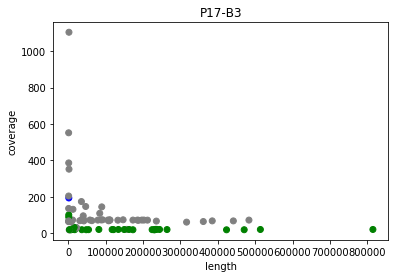

In [98]:
#read in centrifuge output of spades isolate assembly
contigs = pd.read_csv(centrifuge_file,sep='\t')
print(len(contigs),'contigs in spades isolate assembly')

#extract data from contig readIDs and taxIDs
contigs['cov']=pd.to_numeric(contigs['readID'].apply(lambda x: x.split('_')[-1]))
contigs['length']=pd.to_numeric(contigs['readID'].apply(lambda x: x.split('_')[3]))
contigs['taxonomy']=contigs['taxID'].apply(lambda x: get_taxonomy(x))
contigs['genus']=contigs['taxonomy'].apply(lambda x: x.split(' ')[0])

#define contig color based on taxonomy
def color_scale(genus):
    if genus == 'Bacteroides':
        return('blue')
    if genus == 'Parabacteroides':
        return('green')
    if genus == 'Bifidobacterium':
        return('red')
    else:
        return('gray')
contigs['color'] = contigs['genus'].apply(color_scale)

#filter contigs >1,000bp and >10x coverage
contigs = contigs[contigs['length']>1000].reset_index()
contigs = contigs[contigs['cov']>10].reset_index()
print(len(contigs),'contigs >1000bp and 10x coverage')
if len(contigs) == 0: 
    sys.exit('no passing contigs')
#summary contigs by taxonomy
contigs_summary = contigs.groupby(['genus','taxonomy'], as_index=False
                             ).agg({"length": "sum"}
                                  ).sort_values(by=['length'], ascending=False
                                             ).reset_index().drop(columns=['index'])
contigs_summary['length_prop'] = 100*contigs_summary['length']/contigs_summary['length'].sum()
print(contigs_summary.head())
contigs_summary.to_csv(centrifuge_summary_file,sep='\t',index=False)

#plot contig length vs. coverage
plt.figure(1)
plt.scatter(contigs['length'],contigs['cov'],color=contigs['color'])
plt.xlabel('length')
plt.ylabel('coverage')
plt.title(isolate)
plt.savefig(LvC_plot)  

top genus
Escherichia
41 contigs after taxonomic filter


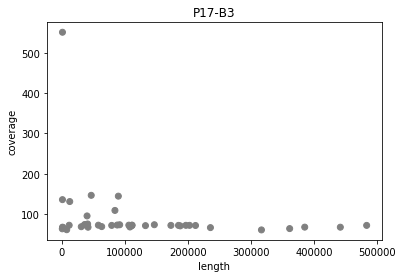

In [100]:
print('top genus')
top_genus = contigs_summary['genus'][0]
print(top_genus)
#filter contigs belonging only to genera01
plt.figure(2)
contigs_TG = contigs[contigs['genus']==top_genus]
print(len(contigs_TG),'contigs after taxonomic filter')

plt.scatter(contigs_TG['length'],contigs_TG['cov'],color=contigs_TG['color'])
plt.xlabel('length')
plt.ylabel('coverage')
plt.title(isolate)

#output filtered contig fasta
with open(fasta_file, "r") as fasta:
    with open(filtered_contigs_fasta_file, "w") as filtered_fasta:
        for record in SeqIO.parse(fasta, "fasta"):
            if record.id in list(contigs_TG['readID']):
                SeqIO.write(record, filtered_fasta, "fasta")